In [1]:
import numpy as np
import keras
from keras import backend as K
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, Bidirectional, LSTM, Dense, TimeDistributed, Dropout
from keras_contrib.layers.crf import CRF
import matplotlib.pyplot as plt
import os
from keras.models import Model
from keras.callbacks import ReduceLROnPlateau
import json
from keras import metrics
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

Using TensorFlow backend.


In [2]:
sample_x = []
sample_y = []
vocabs = {'UNK'}
datas = []
for line in open('/home/wcb/nerXY/train_data/3.3_train.txt', 'r', encoding='utf-8'):
    line = line.rstrip().split('\t')
    if not line:
        continue
    char = line[0]
    if not char:
        continue
    cate = line[-1]
    sample_x.append(char)
    sample_y.append(cate)
    vocabs.add(char)
    if char in ['.', '?', '!']:
        datas.append([sample_x, sample_y])
        sample_x = []
        sample_y = []
word_dict = {wd:index for index,wd in enumerate(list(vocabs))}

In [3]:
file = open('/home/wcb/nerXY/word_dict/3.3_word_dict.txt', 'w') 
for k,v in word_dict.items():
    file.write(str(v) + ' ' + str(k) + '\n')
file.close()

In [4]:
class_dict = {'O':0,
              'I-GEOTS':1,
              'I-ISOAGE':2,
             }
x_train = [[word_dict[char] for char in data[0]] for data in datas]
y_train = [[class_dict[label] for label in data[1]] for data in datas]
x_train = pad_sequences(x_train, maxlen=40, padding='post')
y = pad_sequences(y_train, maxlen=40, padding='post')
y_train = np.expand_dims(y, axis=2)

In [5]:
embeddings_dict = {}
with open('/home/wcb/nerXY/w2v/3.3_w2v.txt', 'r', encoding='utf-8') as f:
    for line in f:
        values = line.strip().split(' ')
        if len(values) < 64:
            continue
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_dict[word] = coefs
print('Found %s word vectors.' % len(embeddings_dict))

embedding_matrix = np.zeros((len(word_dict) + 1, 64))
for word, i in word_dict.items():
    embedding_vector = embeddings_dict.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

Found 1373 word vectors.


In [6]:
model = Sequential()
embedding_layer = Embedding(len(word_dict) + 1,
                            64,
                            weights=[embedding_matrix],
                            input_length=40,
                            trainable=False,
                            mask_zero=True)
model.add(embedding_layer)
model.add(Bidirectional(LSTM(4, return_sequences=True,  activation='softsign')))
model.add(Dropout(0.5))
model.add(TimeDistributed(Dense(len(class_dict))))
crf_layer = CRF(len(class_dict), sparse_target=True)
model.add(crf_layer)
model.compile(optimizer='AdaGrad', loss=crf_layer.loss_function, metrics=[crf_layer.accuracy])
model.summary()










Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



/Users/yvse/opt/anaconda3/envs/keras/lib/python3.7/site-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/Users/yvse/opt/anaconda3/envs/keras/lib/python3.7/site-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 40, 64)            79168     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 40, 8)             2208      
_________________________________________________________________
dropout_1 (Dropout)          (None, 40, 8)             0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 40, 3)             27        
_________________________________________________________________
crf_1 (CRF)                  (None, 40, 3)             27        
Total params: 81,430
Trainable params: 2,262
Non-trainable params: 79,168
_________________________________________________________________


In [7]:
history = model.fit(x_train[:], y_train[:], validation_split=0.10, batch_size=64, epochs=1000)



Train on 2199 samples, validate on 245 samples
Epoch 1/1000
2199/2199 [==============================] - 2s 1ms/step - loss: 1.7793 - crf_viterbi_accuracy: 0.8621 - val_loss: 1.7659 - val_crf_viterbi_accuracy: 0.9092
Epoch 2/1000
2199/2199 [==============================] - 1s 529us/step - loss: 1.6409 - crf_viterbi_accuracy: 0.9109 - val_loss: 1.7300 - val_crf_viterbi_accuracy: 0.9092
Epoch 3/1000
2199/2199 [==============================] - 1s 523us/step - loss: 1.6183 - crf_viterbi_accuracy: 0.9110 - val_loss: 1.7132 - val_crf_viterbi_accuracy: 0.9092
Epoch 4/1000
2199/2199 [==============================] - 1s 526us/step - loss: 1.6036 - crf_viterbi_accuracy: 0.9110 - val_loss: 1.7004 - val_crf_viterbi_accuracy: 0.9092
Epoch 5/1000
2199/2199 [==============================] - 1s 532us/step - loss: 1.5942 - crf_viterbi_accuracy: 0.9111 - val_loss: 1.6901 - val_crf_viterbi_accuracy: 0.9092
Epoch 6/1000
2199/2199 [==============================] - 1s 536us/step - loss: 1.5842 - crf_

Epoch 46/1000
2199/2199 [==============================] - 1s 561us/step - loss: 1.4435 - crf_viterbi_accuracy: 0.9296 - val_loss: 1.5286 - val_crf_viterbi_accuracy: 0.9264
Epoch 47/1000
2199/2199 [==============================] - 1s 562us/step - loss: 1.4396 - crf_viterbi_accuracy: 0.9300 - val_loss: 1.5267 - val_crf_viterbi_accuracy: 0.9267
Epoch 48/1000
2199/2199 [==============================] - 1s 565us/step - loss: 1.4409 - crf_viterbi_accuracy: 0.9305 - val_loss: 1.5255 - val_crf_viterbi_accuracy: 0.9270
Epoch 49/1000
2199/2199 [==============================] - 1s 563us/step - loss: 1.4357 - crf_viterbi_accuracy: 0.9328 - val_loss: 1.5244 - val_crf_viterbi_accuracy: 0.9270
Epoch 50/1000
2199/2199 [==============================] - 1s 563us/step - loss: 1.4371 - crf_viterbi_accuracy: 0.9306 - val_loss: 1.5233 - val_crf_viterbi_accuracy: 0.9276
Epoch 51/1000
2199/2199 [==============================] - 1s 561us/step - loss: 1.4364 - crf_viterbi_accuracy: 0.9307 - val_loss: 1.52

2199/2199 [==============================] - 1s 572us/step - loss: 1.3858 - crf_viterbi_accuracy: 0.9472 - val_loss: 1.4613 - val_crf_viterbi_accuracy: 0.9488
Epoch 141/1000
2199/2199 [==============================] - 1s 575us/step - loss: 1.3884 - crf_viterbi_accuracy: 0.9479 - val_loss: 1.4607 - val_crf_viterbi_accuracy: 0.9494
Epoch 142/1000
2199/2199 [==============================] - 1s 572us/step - loss: 1.3890 - crf_viterbi_accuracy: 0.9460 - val_loss: 1.4605 - val_crf_viterbi_accuracy: 0.9492
Epoch 143/1000
2199/2199 [==============================] - 1s 571us/step - loss: 1.3886 - crf_viterbi_accuracy: 0.9477 - val_loss: 1.4601 - val_crf_viterbi_accuracy: 0.9494
Epoch 144/1000
2199/2199 [==============================] - 1s 572us/step - loss: 1.3887 - crf_viterbi_accuracy: 0.9467 - val_loss: 1.4597 - val_crf_viterbi_accuracy: 0.9498
Epoch 145/1000
2199/2199 [==============================] - 1s 579us/step - loss: 1.3863 - crf_viterbi_accuracy: 0.9474 - val_loss: 1.4597 - val_

2199/2199 [==============================] - 1s 585us/step - loss: 1.3679 - crf_viterbi_accuracy: 0.9553 - val_loss: 1.4358 - val_crf_viterbi_accuracy: 0.9591
Epoch 235/1000
2199/2199 [==============================] - 1s 578us/step - loss: 1.3676 - crf_viterbi_accuracy: 0.9552 - val_loss: 1.4358 - val_crf_viterbi_accuracy: 0.9593
Epoch 236/1000
2199/2199 [==============================] - 1s 581us/step - loss: 1.3679 - crf_viterbi_accuracy: 0.9556 - val_loss: 1.4359 - val_crf_viterbi_accuracy: 0.9595
Epoch 237/1000
2199/2199 [==============================] - 1s 579us/step - loss: 1.3680 - crf_viterbi_accuracy: 0.9559 - val_loss: 1.4351 - val_crf_viterbi_accuracy: 0.9596
Epoch 238/1000
2199/2199 [==============================] - 1s 582us/step - loss: 1.3680 - crf_viterbi_accuracy: 0.9556 - val_loss: 1.4350 - val_crf_viterbi_accuracy: 0.9595
Epoch 239/1000
2199/2199 [==============================] - 1s 582us/step - loss: 1.3667 - crf_viterbi_accuracy: 0.9563 - val_loss: 1.4349 - val_

2199/2199 [==============================] - 1s 585us/step - loss: 1.3579 - crf_viterbi_accuracy: 0.9585 - val_loss: 1.4210 - val_crf_viterbi_accuracy: 0.9677
Epoch 329/1000
2199/2199 [==============================] - 1s 576us/step - loss: 1.3563 - crf_viterbi_accuracy: 0.9604 - val_loss: 1.4210 - val_crf_viterbi_accuracy: 0.9680
Epoch 330/1000
2199/2199 [==============================] - 1s 582us/step - loss: 1.3540 - crf_viterbi_accuracy: 0.9608 - val_loss: 1.4208 - val_crf_viterbi_accuracy: 0.9680
Epoch 331/1000
2199/2199 [==============================] - 1s 582us/step - loss: 1.3576 - crf_viterbi_accuracy: 0.9591 - val_loss: 1.4204 - val_crf_viterbi_accuracy: 0.9685
Epoch 332/1000
2199/2199 [==============================] - 1s 581us/step - loss: 1.3606 - crf_viterbi_accuracy: 0.9579 - val_loss: 1.4206 - val_crf_viterbi_accuracy: 0.9683
Epoch 333/1000
2199/2199 [==============================] - 1s 581us/step - loss: 1.3578 - crf_viterbi_accuracy: 0.9594 - val_loss: 1.4205 - val_

2199/2199 [==============================] - 1s 580us/step - loss: 1.3484 - crf_viterbi_accuracy: 0.9625 - val_loss: 1.4116 - val_crf_viterbi_accuracy: 0.9711
Epoch 423/1000
2199/2199 [==============================] - 1s 580us/step - loss: 1.3494 - crf_viterbi_accuracy: 0.9609 - val_loss: 1.4112 - val_crf_viterbi_accuracy: 0.9712
Epoch 424/1000
2199/2199 [==============================] - 1s 582us/step - loss: 1.3480 - crf_viterbi_accuracy: 0.9618 - val_loss: 1.4113 - val_crf_viterbi_accuracy: 0.9711
Epoch 425/1000
2199/2199 [==============================] - 1s 582us/step - loss: 1.3496 - crf_viterbi_accuracy: 0.9621 - val_loss: 1.4114 - val_crf_viterbi_accuracy: 0.9711
Epoch 426/1000
2199/2199 [==============================] - 1s 580us/step - loss: 1.3499 - crf_viterbi_accuracy: 0.9617 - val_loss: 1.4111 - val_crf_viterbi_accuracy: 0.9712
Epoch 427/1000
2199/2199 [==============================] - 1s 582us/step - loss: 1.3499 - crf_viterbi_accuracy: 0.9622 - val_loss: 1.4111 - val_

2199/2199 [==============================] - 1s 582us/step - loss: 1.3443 - crf_viterbi_accuracy: 0.9635 - val_loss: 1.4039 - val_crf_viterbi_accuracy: 0.9748
Epoch 517/1000
2199/2199 [==============================] - 1s 579us/step - loss: 1.3424 - crf_viterbi_accuracy: 0.9637 - val_loss: 1.4039 - val_crf_viterbi_accuracy: 0.9748
Epoch 518/1000
2199/2199 [==============================] - 1s 581us/step - loss: 1.3419 - crf_viterbi_accuracy: 0.9638 - val_loss: 1.4038 - val_crf_viterbi_accuracy: 0.9748
Epoch 519/1000
2199/2199 [==============================] - 1s 582us/step - loss: 1.3439 - crf_viterbi_accuracy: 0.9640 - val_loss: 1.4040 - val_crf_viterbi_accuracy: 0.9747
Epoch 520/1000
2199/2199 [==============================] - 1s 578us/step - loss: 1.3448 - crf_viterbi_accuracy: 0.9634 - val_loss: 1.4036 - val_crf_viterbi_accuracy: 0.9742
Epoch 521/1000
2199/2199 [==============================] - 1s 581us/step - loss: 1.3423 - crf_viterbi_accuracy: 0.9641 - val_loss: 1.4038 - val_

2199/2199 [==============================] - 1s 580us/step - loss: 1.3396 - crf_viterbi_accuracy: 0.9644 - val_loss: 1.3987 - val_crf_viterbi_accuracy: 0.9780
Epoch 611/1000
2199/2199 [==============================] - 1s 580us/step - loss: 1.3355 - crf_viterbi_accuracy: 0.9668 - val_loss: 1.3986 - val_crf_viterbi_accuracy: 0.9780
Epoch 612/1000
2199/2199 [==============================] - 1s 580us/step - loss: 1.3395 - crf_viterbi_accuracy: 0.9647 - val_loss: 1.3983 - val_crf_viterbi_accuracy: 0.9782
Epoch 613/1000
2199/2199 [==============================] - 1s 581us/step - loss: 1.3372 - crf_viterbi_accuracy: 0.9656 - val_loss: 1.3984 - val_crf_viterbi_accuracy: 0.9776
Epoch 614/1000
2199/2199 [==============================] - 1s 579us/step - loss: 1.3383 - crf_viterbi_accuracy: 0.9657 - val_loss: 1.3985 - val_crf_viterbi_accuracy: 0.9780
Epoch 615/1000
2199/2199 [==============================] - 1s 580us/step - loss: 1.3386 - crf_viterbi_accuracy: 0.9650 - val_loss: 1.3982 - val_

2199/2199 [==============================] - 1s 583us/step - loss: 1.3340 - crf_viterbi_accuracy: 0.9680 - val_loss: 1.3934 - val_crf_viterbi_accuracy: 0.9795
Epoch 705/1000
2199/2199 [==============================] - 1s 581us/step - loss: 1.3363 - crf_viterbi_accuracy: 0.9663 - val_loss: 1.3935 - val_crf_viterbi_accuracy: 0.9795
Epoch 706/1000
2199/2199 [==============================] - 1s 580us/step - loss: 1.3370 - crf_viterbi_accuracy: 0.9663 - val_loss: 1.3933 - val_crf_viterbi_accuracy: 0.9803
Epoch 707/1000
2199/2199 [==============================] - 1s 582us/step - loss: 1.3342 - crf_viterbi_accuracy: 0.9675 - val_loss: 1.3936 - val_crf_viterbi_accuracy: 0.9795
Epoch 708/1000
2199/2199 [==============================] - 1s 580us/step - loss: 1.3366 - crf_viterbi_accuracy: 0.9659 - val_loss: 1.3933 - val_crf_viterbi_accuracy: 0.9795
Epoch 709/1000
2199/2199 [==============================] - 1s 583us/step - loss: 1.3344 - crf_viterbi_accuracy: 0.9676 - val_loss: 1.3931 - val_

2199/2199 [==============================] - 1s 558us/step - loss: 1.3334 - crf_viterbi_accuracy: 0.9675 - val_loss: 1.3895 - val_crf_viterbi_accuracy: 0.9818
Epoch 799/1000
2199/2199 [==============================] - 1s 573us/step - loss: 1.3315 - crf_viterbi_accuracy: 0.9675 - val_loss: 1.3895 - val_crf_viterbi_accuracy: 0.9818
Epoch 800/1000
2199/2199 [==============================] - 1s 552us/step - loss: 1.3319 - crf_viterbi_accuracy: 0.9679 - val_loss: 1.3896 - val_crf_viterbi_accuracy: 0.9818
Epoch 801/1000
2199/2199 [==============================] - 1s 561us/step - loss: 1.3318 - crf_viterbi_accuracy: 0.9679 - val_loss: 1.3894 - val_crf_viterbi_accuracy: 0.9818
Epoch 802/1000
2199/2199 [==============================] - 1s 566us/step - loss: 1.3325 - crf_viterbi_accuracy: 0.9673 - val_loss: 1.3890 - val_crf_viterbi_accuracy: 0.9820
Epoch 803/1000
2199/2199 [==============================] - 1s 565us/step - loss: 1.3348 - crf_viterbi_accuracy: 0.9670 - val_loss: 1.3890 - val_

2199/2199 [==============================] - 1s 607us/step - loss: 1.3277 - crf_viterbi_accuracy: 0.9698 - val_loss: 1.3863 - val_crf_viterbi_accuracy: 0.9829
Epoch 893/1000
2199/2199 [==============================] - 1s 595us/step - loss: 1.3295 - crf_viterbi_accuracy: 0.9693 - val_loss: 1.3862 - val_crf_viterbi_accuracy: 0.9831
Epoch 894/1000
2199/2199 [==============================] - 1s 595us/step - loss: 1.3258 - crf_viterbi_accuracy: 0.9699 - val_loss: 1.3864 - val_crf_viterbi_accuracy: 0.9823
Epoch 895/1000
2199/2199 [==============================] - 1s 581us/step - loss: 1.3301 - crf_viterbi_accuracy: 0.9696 - val_loss: 1.3862 - val_crf_viterbi_accuracy: 0.9831
Epoch 896/1000
2199/2199 [==============================] - 1s 587us/step - loss: 1.3292 - crf_viterbi_accuracy: 0.9700 - val_loss: 1.3862 - val_crf_viterbi_accuracy: 0.9829
Epoch 897/1000
2199/2199 [==============================] - 1s 581us/step - loss: 1.3298 - crf_viterbi_accuracy: 0.9696 - val_loss: 1.3859 - val_

2199/2199 [==============================] - 1s 573us/step - loss: 1.3248 - crf_viterbi_accuracy: 0.9713 - val_loss: 1.3834 - val_crf_viterbi_accuracy: 0.9839
Epoch 987/1000
2199/2199 [==============================] - 1s 590us/step - loss: 1.3281 - crf_viterbi_accuracy: 0.9696 - val_loss: 1.3833 - val_crf_viterbi_accuracy: 0.9839
Epoch 988/1000
2199/2199 [==============================] - 1s 592us/step - loss: 1.3289 - crf_viterbi_accuracy: 0.9697 - val_loss: 1.3832 - val_crf_viterbi_accuracy: 0.9839
Epoch 989/1000
2199/2199 [==============================] - 1s 597us/step - loss: 1.3300 - crf_viterbi_accuracy: 0.9696 - val_loss: 1.3830 - val_crf_viterbi_accuracy: 0.9839
Epoch 990/1000
2199/2199 [==============================] - 1s 589us/step - loss: 1.3276 - crf_viterbi_accuracy: 0.9708 - val_loss: 1.3832 - val_crf_viterbi_accuracy: 0.9837
Epoch 991/1000
2199/2199 [==============================] - 1s 585us/step - loss: 1.3268 - crf_viterbi_accuracy: 0.9700 - val_loss: 1.3833 - val_

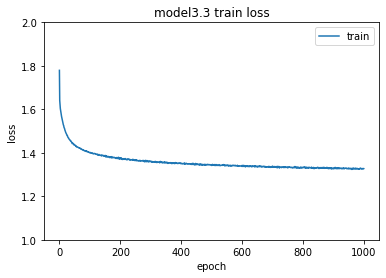

In [9]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'])
pyplot.title('model3.3 train loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train'], loc='upper right')
pyplot.ylim([1,2])

In [12]:
model.save('/home/wcb/nerXY/model/model3.3.h5')